# Проект № 7: Принятие решений в бизнесе на основе данных

## Описание проекта

Мы — аналитики крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Проект состоит из двух частей:**

* Часть 1. Необходимо приоритизировать гипотезы.
* Часть 2. Запустить A/B-тест и проанализировать результаты.

## Описание данных

**Данные для первой части проекта:**

Структура **hypothesis.csv** 
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части проекта:**

Структура **orders.csv**
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Структура **visitors.csv** 
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Обзор и преобработка данных

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np

from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import timedelta
import datetime as dt

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

pd.options.display.max_colwidth = 150  

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# сохраним данные в соответствующие переменные
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
# напишем функцию для первичного ознакомления (общая информация и первые пять строк датасета)
def dataset_info(dataset_name):
    dataset_name.info()
    print()
    display(dataset_name.head())

# с помощью цикла пройдёмся по всем датасетам    
for dataset in [hypothesis, orders, visitors]:
    print('-'*50)
    print()
    dataset_info(dataset)
    print()

--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes



,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB



,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Пропусков в таблицах нет, названия столбцов в таблице `orders` к нижнему регистру приводить не будем для удобства восприятия.

Необходимо будет изменить тип данных с датами **_object_** на **_datetime_** и привести названия столбцов таблицы `hypothesis` к нижнему регистру.

Так же необходимо проверить значения таблиц на наличие различных аномалий.

### Таблица hypothesis

In [4]:
# приведём названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [5]:
# посмотрим описательную статистику таблицы hypothesis
hypothesis.describe()

,reach,impact,confidence,efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Значения параметров представлены в диапазоне от 1 до 10, что соответствует описанию таблицы.

### Таблица orders

In [6]:
# проверим уникальность id заказов в столбце transactionId
orders['transactionId'].value_counts()

3667963787    1
4167421281    1
2875229767    1
504373597     1
2017680897    1
             ..
1853288890    1
2084190534    1
2956594374    1
3646798055    1
3936777065    1
Name: transactionId, Length: 1197, dtype: int64

В таблице 1197 уникальных заказов.

In [7]:
# изменим тип данных для orders
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# проверим
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
# проверим уникальность id пользователей в столбце transactionId
orders['visitorId'].value_counts()

4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2524310328     1
2210805728     1
2274825520     1
1831227158     1
2108080724     1
Name: visitorId, Length: 1031, dtype: int64

В таблице 1031 уникальных пользователей, совершивших заказ. Два пользователя совершили по 11 заказов.

In [9]:
# посчитаем общее количество покупок
orders['visitorId'].count()

1197

С заказами и пользователями всё в порядке.

In [10]:
# посмотрим информацию о датах
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

1197 значений, данные собирались за 31 день, больше всего покупок было совершено 5 августа 2019 года.

In [11]:
# посмотрим значения выручки
orders['revenue'].describe().apply("{0:.1f}".format)

count       1197.0
mean        8348.0
std        39191.1
min           50.0
25%         1220.0
50%         2978.0
75%         8290.0
max      1294500.0
Name: revenue, dtype: object

Отрицательных и нулевых значений нет. 

In [12]:
# посмотрим сколько значений в каждой группе
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

В колонке с группами тестирования неравное количество участников: в группе А - 557 человек, в группе B - 640.

In [13]:
# проверим на наличие дубликатов
orders[orders.duplicated()]

,transactionId,visitorId,date,revenue,group


Дубликаты отсутствуют.

### Таблица visitors

In [14]:
# изменим тип данных для таблицы visitors
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# проверим
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [15]:
# проверим даты на аномалии
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-01 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [16]:
# посмотрим сколько значений в каждой группе
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

Всего 62 строки, каждая дата повторяется по 2 раза (для групп А и В), всё в порядке.

In [17]:
# посмотрим описательную статистику по посетителям
visitors['visitors'].describe()

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

Всего 62 строки с информацией о числе посетителей. Среднее и медиана близки (607 и 62 соответственно). Самое большое число посетителей - 770, самое маленькое - 361. 

In [18]:
# проверим на наличие дубликатов
visitors[visitors.duplicated()]

,date,group,visitors


Дубликаты отсутствуют.

In [19]:
# проверим, есть ли кто-то из покупателей сразу в двух группах
doubled_group = orders.groupby('visitorId').agg({'group':'nunique'})
doubled_group = doubled_group.query('group > 1')
doubled_group['group'].count()

58

Было выявлено, что 58 пользователей, оказавшихся в обеих группах. Так как их количество незначительно, то оставим всё как есть.

### Вывод

Данные подготовлены для дальнейшего анализа.

Таблица с гипотезами `hypothesis`:
* названия столбцов приведены к нижнему регистру;
* параметры имеют значения от 1 до 10, оценка имеет 10-балльную шкалу.

Таблица с заказами `orders`:
* дата приведена к типу данных datetime;
* в значениях не выявлено аномалий;
* присутствуют данные за август 2019 года;
* присутствуют 1197 уникальных заказов;
* присутствуют 1031 уникальных пользователя;
* самое большое число заказов на одного покупателя - 11;
* больше всего заказов совершено 5 августа 2019 года - 48 заказов;
* в столбце с группами теста неравное число участников: в группе А - 557 человек, в группе B - 640;
* дубликаты, нулевые и отрицательные значения отсутствуют.

Таблица с данными о посещениях `visitors`:

* дата приведена к типу данных datetime;
* каждая дата повторяется по 2 раза (для групп А и В), уникальных значений - 31, так же, как и в датасете с заказами;
* cреднее и медиана числа посетителей близки (607 и 62 соответственно), скорее всего, сильных выбросов нет;
* самое большое число посетителей - 770, самое маленькое - 361;
* дубликаты, нулевые и отрицательные значения отсутствуют.

Так же было проверено наличие пользователей одновременно в друх группах. Так как их количество незначительное (58 человек), то приняли решение оставить всё как есть.

## Часть 1. Приоритизация гипотез

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

**Задача:**
1. Применить фреймворк **ICE** для приоритизации гипотез. Отсортировать их по убыванию приоритета.
2. Применить фреймворк **RICE** для приоритизации гипотез. Отсортировать их по убыванию приоритета.
3. Указать, как изменилась приоритизация гипотез при применении **RICE** вместо **ICE**. Объяснить, почему так произошло.

In [20]:
# посмотрим таблицу со всеми гипотезами
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Применение фреймворка ICE для приоритизации гипотез

In [21]:
# добавим столбец ICE в таблицу с гипотезами
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


### Применение фреймворка RICE для приоритизации гипотез

In [22]:
# добавим столбец RICE в таблицу с гипотезами
hypothesis['rice'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)

hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [23]:
# посмотрим таблицу целиком, добавим цвета ячеек в зависимости от значения
hypothesis[['hypothesis', 'ice', 'rice']].style.background_gradient('coolwarm')

,hypothesis,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.300000,40.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.100000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.300000,4.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000


### Вывод:

Для приоритизации гипотез мы применили одни из самых распространённых методов - **ICE** (Impact — влияние, Confidence — уверенность, Ease — легкость реализации) и **RICE** (Reach — охват, Impact — влияние, Confidence — достоверность, Effort — усилия).

В ходе первой части исследования приоритизированы 9 предоставленных гипотез по увеличению выручки интернет-магазина.

После применения фрейморка **ICE** наиболее приоритетными гипотезами являются:

1. Запустить акцию, дающую скидку на товар в день рождения **(Гипотеза № 9)**
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей **(Гипотеза № 1)**
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок **(Гипотеза № 8)**

После применения фрейморка **RICE** наиболее приоритетными гипотезами являются:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок **(Гипотеза № 8)**
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа **(Гипотеза № 3)**
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей **(Гипотеза № 1)**

На основе этих данных, рекомендуется в первую очередь проверить следующие гипотезы:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок **(Гипотеза № 8)**
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей **(Гипотеза № 1)**

**Причина изменения приоритизации гипотез при применении RICE вместо ICE:**

Причина изменения приоритизации гипотез заключается в том, что фреймворк RICE содержит ещё одну переменную «Reach — охват», которая показывает сколько пользователей затронет эта фича за определенный период, то есть охват пользователей. По этой причине, гипотезы с бо́льшим охватом аудитории оказываются выше по приоритету при применении RICE вместо ICE.

Например, по причине того, что «Запустить акцию, дающую скидку на товар в день рождения **(Гипотеза № 9)**» имеет оценку Reach равную **1** - меньше всех из приведённых гипотез, то при использовании фреймворка **RICE** эта гипотеза уже не занимает не первое, а пятое место.

## Часть 2. Анализ A/B-теста

## Изучение кумулятивных метрик

### График кумулятивной выручки по группам

In [24]:
# создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Объявим переменную ordersAggregated, содержащую:

* дату;
* группу A/B-теста;
* число уникальных заказов в группе теста по указанную дату включительно;
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
* суммарную выручку заказов в группе теста по указанную дату включительно.

In [25]:
# получим агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [26]:
# посмотрим первые пять строк таблицы
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Объявим переменную `visitorsAggregated`, содержащую:

* дату;
* группу A/B-теста;
* количество уникальных посетителей в группе теста по указанную дату включительно.

In [27]:
# получим агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [28]:
# посмотрим первые пять строк таблицы
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Определим переменную `cumulativeData,` объединив `ordersAggregated` и `visitorsAggregated` по колонкам **'date', 'group'** методом merge().

In [29]:
# объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [30]:
# посмотрим первые пять строк таблицы
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Объявим переменные `cumulativeRevenueA` и `cumulativeRevenueB`, в которых сохраним данные о датах, выручке и числе заказов в группах A и B. Построим графики кумулятивной выручки по дням по группам.

In [31]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [32]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


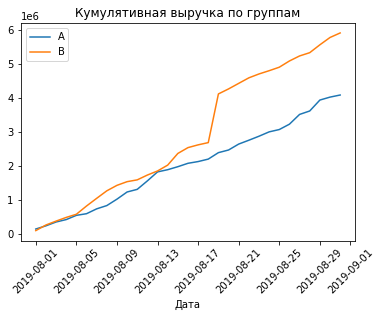

In [33]:
# построим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# построим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)
plt.legend() 
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.show();

С самого начала группа B вырвалась вперёд и продолжала лидировать весь остаток теста. В середине августа наблюдаем резкий скачок выручки группы B. Вполне возможно, что произошёл всплеск покупательской активности: выросло числов заказов, увеличилась для дорогих заказов в выборке, повлияли аномально большие заказы и т.д.

### График кумулятивного среднего чека по группам

Для построения графика среднего чека по группам разделим кумулятивную выручку на кумулятивное число заказов.

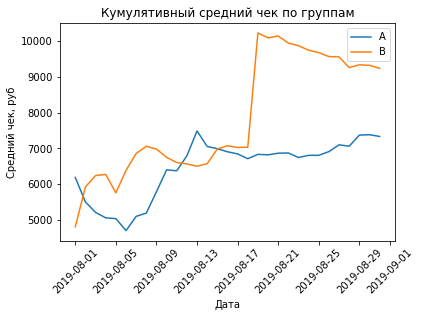

In [34]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек, руб')
plt.legend() 
plt.show();

Кумулятивное значение среднего чека по группам продолжает колебаться. После 17 августа со средним чеком группы В что-то случилось, и он резко увеличился (стал свыше 10000), затем после резкого скачка у группы В наблюдаем стабильное уменьшение среднего чека. Пик для группы А пришёлся на 13 августа (около 7500), после чего немного снизился и стабилизировался.

Скорее всего, принимать решение по этой метрике рано. Требуется дополнительный анализ выбросов, которые так сильно искажают результаты.

### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия кумулятивного среднего чека группы B к группе A.

Добавим пунктирную линию оси X (значение оси Y = 0) методом plt.axhline().

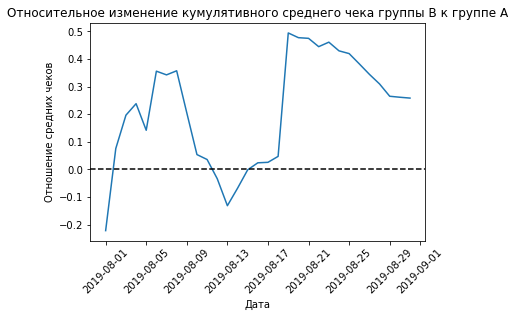

In [35]:
# соберём данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
                          cumulativeRevenueB, 
                          left_on='date', 
                          right_on='date', 
                          how='left', 
                          suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков')
plt.show();

Результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершены аномальные заказы.

### График кумулятивной конверсии по группам

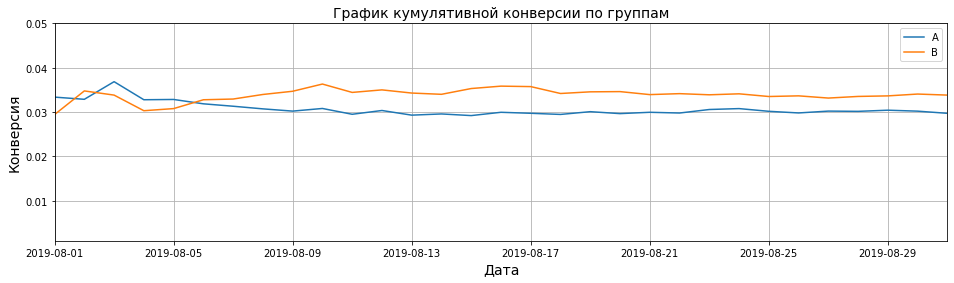

In [36]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


# строим графики
plt.figure(figsize=(16,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.001, 0.05])
plt.title('График кумулятивной конверсии по группам', size=14)
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия', size=14)
plt.legend()
plt.grid()
plt.show()

В начале теста до 5 августа обе группы колебались вокруг одного значения. После этого конверсия группы B вырывается вперёд и фиксируется около одного значения. Конверсия группы А с 9 августа тоже зафиксировалась на одном значении (около 0.03).

### График относительного изменения кумулятивной конверсии группы B к группе A

In [37]:
# объединим таблицы cumulativeDataA и cumulativeDataB методом merge() 
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


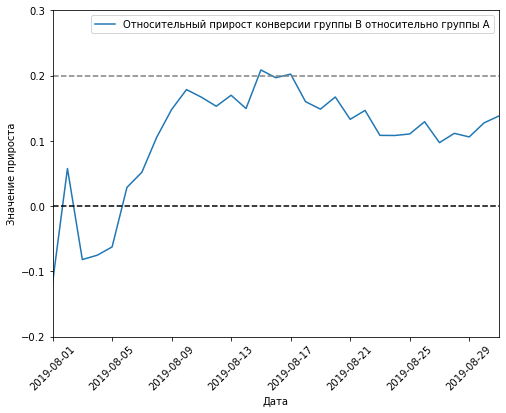

In [38]:
# построим график относительного различия кумулятивной конверсии группы B к группе A.
plt.figure(figsize=(8,6))
plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
    label="Относительный прирост конверсии группы B относительно группы A"
)
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение прироста')

plt.xticks(rotation=45)

# добавим пунктирную линию оси X чёрного цвета ('black') со значением оси Y = 0 методом plt.axhline(). 
plt.axhline(y=0, color='black', linestyle='--')
# и ещё одну линию оси X серого цвета ('grey') со значением оси Y = 0.2.
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3])

plt.show()

В начале теста группа B уступала группы A, затем вырвалась резко вперёд 2 августа, а потом упала вновь 3 августа. Затем группа B начала расти вплоть до 15 августа, после чего стала немного падать до 0.1, но все равно выигрывает по сравнению с группой А. В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

## Анализ выбросов и всплесков

### Точечный график количества заказов по пользователям

In [39]:
# Метод .groupby('...', as_index=False) сгруппирует заказы по пользователям
# Метод .agg({'...' : 'nunique',}) подсчитает число уникальных заказов по сгруппированным данным
ordersByUsers  = orders.drop(['group', 'revenue', 'date'], 
                             axis=1).groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']

# Метод .sort_values(by='...',ascending=False) отсортирует датафрейм по значению в столбце

ordersByUsers.sort_values(by='orders', ascending=False)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


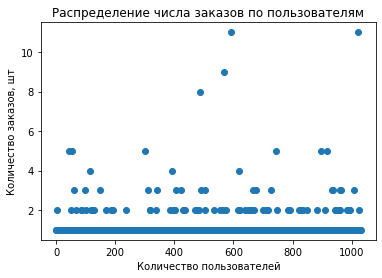

In [40]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 

plt.title('Распределение числа заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов, шт')
plt.show()

Пользователей, заказавших более двух раз, совсем мало. Они вполне могут быть аномальными.

### 95-й и 99-й перцентили количества заказов на пользователя

In [41]:
# метод np.percentile('column', [percentile1, percentile2]) находит перцентили
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей - больше четырех заказов.

### Точечный график стоимостей заказов

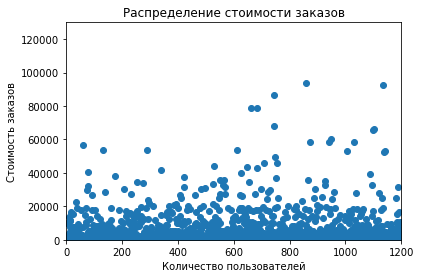

In [42]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue']) 

plt.title('Распределение стоимости заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.axis([0, 1200, 0, 130000])

plt.show()

Больших заказов не так уж и много. Присутствуют выбросы в районе 40000-100000. 

### 95-й и 99-й перцентили стоимости заказов

In [43]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более, чем у 5% заказов стоимость заказов выше 28000. И не более, чем у 1% стоимость заказов выше 58233.

## Проведение A/B-теста

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы. Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

* H0 - Вероятность того, что наблюдение из группы B превышает наблюдение из группы A равна 50%
* H1 - Вероятность того, что наблюдение из группы B превышает наблюдение из группы A не равна 50%

In [44]:
# подготовим данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


**Напомним названия столбцов данных:**

* `date` — дата;
* `ordersPerDateA` — количество заказов в выбранную дату в группе A;
* `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
* `ordersPerDateB` — количество заказов в выбранную дату в группе B;
* `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
* `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
* `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
* `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
* `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
* `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
* `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в конверсии между группами.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами **'userId', 'orders'**. 

В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [45]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

Объявим переменные **sampleA** и **sampleB**, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [46]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [47]:
# выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1
# округлим до трёх знаков после запятой

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


Первое число — p-value равно 0.017 и оно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. 

Анализ «сырых» данных показывает, что в конверсии между группами есть статистически значимые различия. Отдельный прирост конверсии группы В к конверсии группы А равен 13.8% (нулевая гипотеза всегда приравнивает, значит Н1 - статистически значимые различия в группах имеются).

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

* **Н0:** различий в среднем чеке между группами нет. 
* **H1:** различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.

А ещё найдём относительные различия в среднем чеке между группами.

In [48]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно ниже среднего чека группы A.

Кроме того, относительное различие среднего чека между сегментами 25.9%, это довольно-таки много. Вероятнее всего, тут аномалии с двух сторон, с которыми следует поработать.

### Очистка данных

95 и 99 перцентили средних чеков равны 28000 и 58233 рублям. 95 и 99 перцентили числа заказов на одного пользователя равны 2 и 4.

Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 28000.

Сначала определим аномальные заказы, затем пользователей, совершивших их и добавим их в список аномальных.

In [49]:
# узнаем, сколько всего аномальных пользователей методом shape()
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head())
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
74


Всего 74 аномальных пользователей. 

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [50]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [51]:
# применим статистический критерий Манна-Уитни к полученным выборкам:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.013
0.173


Как и в случае с сырыми данными, статистическая значимость достигнута. Отвергаем нулевую гипотезу. Сегмент B лучше сегмента А. Относительный прирост конверсии очищенной группы B к А увеличился на 3.5% и равен 17.3%

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [52]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], 
            True, # что бы задать 4ый параметр 
            'two-sided' # для двух-стороннего теста
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


После очистки данных от аномалий p-value по среднему чеку не практически не изменился, нулевая гипотеза отвергается, поэтому статистически значимых отличий между группами нет. Относительное различие группы В относительно группы А, после очистки данных упало на 27.9%. И составляет всего 2% в пользу группы А.

### Решение по результатам A/B-теста 

По результатам A/B-теста мы приняли решение остановить тест, признать его успешным, зафиксировать победу группы B и перейти к проверке следующей гипотезы.

* есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий; 
* конверсия группы B увеличилась по сравнению с группой A, при этом статистически значимых различий в среднем чеке заказа между группами нет.

## Вывод

Для исследования нам были предоставлены входные данные, содержащие информацию о 9 предоставленных гипотезах по увеличению выручки нашего интернет-магазина, данные о заказах и данные о посещениях.

**Исследование состояло из двух частей:**

* Часть 1. Необходимо приоритизировать гипотезы.
* Часть 2. Запустить A/B-тест и проанализировать результаты.

**Предобработка**

Перед началом исследования мы изучили предоставленные данные и провели их преобработку.

По результатам которых можно сделать следующие выводы:
* Представлены заказы за c 1 по 31 августа 2019 года;
* Всего 1197 заказов, совершенных 1031 уникальным пользователем;
* Cамое большое число заказов, совершённых одним покупателем - 11;
* Больше всего заказов было сделано 5 августа 2019 года - 48;
* Каждая дата повторяется по 2 раза (для групп А и В), уникальных значений - 31, так же, как и в датасете с заказами;
* Было выявлено, что 58 покупателей, оказались сразу в обеих группах. Так как их количество незначительно, то оставим всё как есть.


**Часть 1. Приоритизация гипотез.**

В ходе первой части исследования приоритизированы 9 предоставленных гипотез по увеличению выручки интернет-магазина.

Для приоритизации гипотез мы применили одни из самых распространённых методов - **ICE** (Impact — влияние, Confidence — уверенность, Ease — легкость реализации) и **RICE** (Reach — охват, Impact — влияние, Confidence — достоверность, Effort — усилия).

После применения фрейморка **ICE** наиболее приоритетной гипотезой является:

1. Запустить акцию, дающую скидку на товар в день рождения **(Гипотеза № 9)**
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей **(Гипотеза № 1)**
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок **(Гипотеза № 8)**

После применения фрейморка **RICE** наиболее приоритетными гипотезами являются:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок **(Гипотеза № 8)**
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа **(Гипотеза № 3)**
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей **(Гипотеза № 1)**

На основе этих данных, рекомендуется в первую очередь проверить следующие гипотезы:

1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок **(Гипотеза № 8)**
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей **(Гипотеза № 1)**


**Часть 2. A/B-тест**

Во второй части проекта выполнен анализ результатов A/B-теста, который был проведён с целью увеличения выручки.

Посчитана статистическая значимость различий между группами по «сырым» и «очищенным» данным.

95 и 99 перцентили средних чеков равны 28000 и 58233 рублям. 95 и 99 перцентили числа заказов на одного пользователя равны 2 и 4. Мы приняли за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ дороже 28000.

1. **Статистическая значимость различий в конверсии между группами:**

**«Сырые» данные:** 
* P-value равно 0.017 и оно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем;
* Анализ «сырых» данных показывает, что в конверсии между группами есть статистически значимые различия. Отдельный прирост конверсии группы В к конверсии группы А равен 13.8% (нулевая гипотеза всегда приравнивает, значит Н1 - статистически значимые различия в группах имеются).

**«Очищенные» данные:**
* Как и в случае с сырыми данными, статистическая значимость достигнута. Отвергаем нулевую гипотезу. Сегмент B лучше сегмента А. Относительный прирост конверсии очищенной группы B к А увеличился на 3.5% и равен 17.3%.

2. **Статистическая значимость различий в среднем чеке между группами:**

**«Сырые» данные:** 
* P-value равен и 0.729 значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно ниже среднего чека группы A;
* Кроме того, относительное различие среднего чека между сегментами 25.9%, это довольно-таки много. Вероятнее всего, тут аномалии с двух сторон, с которыми следует поработать.

**«Очищенные» данные:**
* После очистки данных от аномалий p-value по среднему чеку не практически не изменился (0.738), нулевая гипотеза отвергается, поэтому статистически значимых отличий между группами нет. Относительное различие группы В относительно группы А, после очистки данных упало на 27.9%. И составляет всего 2% в пользу группы А.

**Результат A/B-теста.**

Исходя из полученных результатов, и несмотря на то, что по среднему чеку статистической значимости не обнаружено, мы решили остановить A/B-тест и зафиксировать победу группы B. 

Есть статистически значимое различие по конверсии между группами, как по «сырым» данным, так и после фильтрации аномалий. Так как наша задача состоит в оценке эффективности гипотезы по увеличению выручки интернет-магазина, то группа В лучше, чем группа А, по причине того, что конверсия у неё больше, даже с учётом того, что средний чек остался без изменений - соответственно группа В приносит больше прибыли бизнесу.